tournament_scores:
- https://drive.google.com/file/d/1ZOTWOaJoNcIy6hdMWY8ZuNZ7TtZsdhyk/view?usp=sharing

tournaments:
- https://drive.google.com/file/d/1GKPdZcNmrsLcEprOgsRVWWqc4JYNxuV0/view?usp=sharing

units:
- https://drive.google.com/file/d/11QFHtU6ygpwEC6O__2vMR0GtOBfyERVA/view?usp=sharing

total_scores:
- https://drive.google.com/file/d/1kb15eqLsUaMk6dSxeQDJKA0N1ivI7rms/view?usp=sharing

scores:
- https://drive.google.com/file/d/1USchZZKNYBqbKQgMoGddbvJ4AhLWhkDD/view?usp=sharing

# Спортивная школа фигурного катания

**Заказчик:**

Компания GoProtect

**Описание проекта**

Сервис  “Мой Чемпион” помогает спортивным школам фигурного катания, тренерам мониторить результаты своих подопечных и планировать дальнейшее развитие спортсменов.

**Цель**

Создать модель, помогающую находить элементы, которые могут быть успешно исполнены спортсменом на соревновании.

 Сервис будет прогнозировать прогресс и возможное выполнение тех или иных элементов программы по истории предыдущих выступлений и выполнения элементов на соревнованиях.

**Описание данных**

`units`

- id: идентификатор юнита
- color: категория
- school_id: идентификатор школы

`tournaments`

- id: идентификатор турнира
- date_start: дата начала
- date_end: дата завершения
- origin_id: место проведения

`total_scores`

- id: идентификатор выступления, джойнится с tournament_scores.total_score_id
- unit_id: идентификатор юнита, ключ к units.id
- tournament_id: идентификатор турнира, tournaments.id
- components_score: артистизм (мастерство, композиция, хореография)
- base_score: базовая оценка за элементы в выступлении (идеал)
- elements_score: реальная оценка всех выполненных элементов, base_score+goe
- decreasings_score: снижения оценок за ошибки
- total_score: components_score+elements_score+decreasings_score за выступление
- starting_place:
- place: занятое место в категории category_name+segment_name
- segment_name: название сегмента
- info: комментарии и пояснения к оценке
- overall_place: итоговое место в турнире
- overall_total_score: итоговая оценка за весь турнир
- overall_place_str: комментарии, пояснения

`tournament_scores`
Таблица с оценками поэлементно
- id: идентификатор оценки за конкретный элемент/комбинацию
- total_score_id: идентикатор выступления, ключ total_scores.id
- title: запись элемента или комбинации элементов с отметками об ошибках
- decrease: за что снижена оценка
- base_score: базовая оценка (идеал, цена данного элемента/комбинации, сложность)
- goe: Grade of Execute, качество исполнения, судейские надбавки/убавки
- avg_score: оценка за элемент/комбинацию (усредненная по судьям)

**Структура работы**

- Загрузка данных
- Объединение таблиц
- Анализ данных
    - Поиск зависимостей между данными
- Обучение моделей
    - Предсказание итогового балла за прокат
    - Мониторинг результатов спортсмена
    - Рекомендательная система для изучения новых элементов

# Подключение библиотек

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
import re

from sklearn.feature_extraction.text import (
    TfidfVectorizer,
    CountVectorizer
)
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import mean_squared_error

In [2]:
# системные настройки
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

In [3]:
#Объявим константы

RANDOM_STATE = 42

# Загрузка данных

In [4]:
#Команда для скачивания с гугл диска
! gdown --id 1ZOTWOaJoNcIy6hdMWY8ZuNZ7TtZsdhyk
! gdown --id 1GKPdZcNmrsLcEprOgsRVWWqc4JYNxuV0
! gdown --id 11QFHtU6ygpwEC6O__2vMR0GtOBfyERVA
! gdown --id 1kb15eqLsUaMk6dSxeQDJKA0N1ivI7rms
! gdown --id 1USchZZKNYBqbKQgMoGddbvJ4AhLWhkDD


/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1ZOTWOaJoNcIy6hdMWY8ZuNZ7TtZsdhyk
To: /content/tournament_scores.csv
100% 5.84M/5.84M [00:00<00:00, 97.5MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1GKPdZcNmrsLcEprOgsRVWWqc4JYNxuV0
To: /content/tournaments.csv
100% 4.27k/4.27k [00:00<00:00, 8.26MB/s]
/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From

In [5]:
# Счмитывание данных из файлов
df_tournament_scores = pd.read_csv('/content/tournament_scores.csv')
df_tournaments = pd.read_csv('/content/tournaments.csv')
df_units = pd.read_csv('/content/units.csv')
df_total_scores = pd.read_csv('/content/total_scores.csv')
base_scores = pd.read_csv('/content/scores.csv')

In [6]:
df_tournament_scores.head()

,id,total_score_id,title,decrease,base_score,goe,avg_score
0,1,1,2A,NaN,3.3,0.66,3.96
1,2,1,3F+3Lo,NaN,10.2,-0.11,10.09
2,3,1,3Lz,NaN,0.0,-1.30,5.19
3,4,1,CCoSp4,NaN,3.5,0.56,4.06
4,5,1,FCSp4,NaN,3.2,0.64,3.84


In [7]:
df_tournaments.head()

,id,date_start,date_end,origin_id
0,1,2090-11-29,2090-12-01,2.0
1,2,2091-03-06,2091-03-10,1.0
2,3,2090-10-05,2090-10-08,2.0
3,4,2090-10-18,2090-10-21,2.0
4,5,2090-10-21,2090-10-24,2.0


In [8]:
df_units.head(3)

,id,color,school_id
0,9474,green,244.0
1,733,green,203.0
2,734,green,235.0


In [9]:
df_total_scores.head(3)

,id,unit_id,tournament_id,base_score,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str
0,442027,304,4785,47.2,43.47,102.70,59.23,0.0,17,1,Короткая программа,x Надбавка за прыжки во второй половине програ...,2,293.74,2
1,442028,604,4785,45.4,46.71,101.19,54.48,0.0,18,2,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,1,294.75,1
2,442029,409,4785,44.0,46.82,99.20,52.38,0.0,6,3,Короткая программа,q Прыжок приземлён в четверть x Надбавка за пр...,4,285.57,4


In [10]:
base_scores.head(3)

,element,decrease-5,decrease-4,decrease-3,decrease-2,decrease-1,base,increase+1,increase+2,increase+3,increase+4,increase+5
0,1T,-0.20,-0.16,-0.12,-0.08,-0.04,0.4,0.04,+0.08,+0.12,+0.16,0.20
1,1S,-0.20,-0.16,-0.12,-0.08,-0.04,0.4,0.04,+0.08,+0.12,+0.16,0.20
2,1Lo,-0.25,-0.20,-0.15,-0.10,-0.05,0.5,0.05,+0.10,+0.15,+0.20,0.25


In [11]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>missing_values(...):

def missing_values(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для подсчета, процента пропусков в датасете
    """
    percent_missing = round(df.isnull().sum() * 100 / df.shape[0])
    percent_missing = percent_missing.astype(int)
    missing = df.isnull().sum()
    df_missing = pd.DataFrame({'column_name': df.columns, 'missing_count': missing, 'percent_missing': percent_missing}).sort_values(by='missing_count')
    df_missing = df_missing.reset_index(drop=True)
    return df_missing

In [12]:
# Количество пропусков в ДС df_total_scores
missing_values(df_total_scores)

,column_name,missing_count,percent_missing
0,id,0,0
1,unit_id,0,0
2,tournament_id,0,0
3,base_score,0,0
4,components_score,0,0
5,total_score,0,0
6,elements_score,0,0
7,decreasings_score,0,0
8,starting_place,0,0
9,place,0,0


In [13]:
# Количество пропусков в ДС df_tournament_scores
missing_values(df_tournament_scores)

,column_name,missing_count,percent_missing
0,id,0,0
1,total_score_id,0,0
2,title,0,0
3,base_score,0,0
4,goe,0,0
5,avg_score,0,0
6,decrease,130973,76


In [14]:
# Количество пропусков в ДС df_units
missing_values(df_units)

,column_name,missing_count,percent_missing
0,id,0,0
1,color,1,0
2,school_id,589,13


In [15]:
# Количество пропусков в ДС df_tournaments
missing_values(df_tournaments)

,column_name,missing_count,percent_missing
0,id,0,0
1,date_start,0,0
2,date_end,0,0
3,origin_id,0,0


# Объеденение таблиц

Объеденим все таблицы в единый датасет

In [16]:
df = pd.merge(df_total_scores, df_tournament_scores, left_on='id', right_on='total_score_id', suffixes=('_total_scores', '_tournament_scores'), how='outer')

In [17]:
df = pd.merge(df, df_units, left_on='unit_id', right_on='id', suffixes=('_', '_unit_id'), how='left')


In [18]:
df = pd.merge(df, df_tournaments, left_on='tournament_id', right_on='id', suffixes=('_', '_tournaments'), how='outer')

In [19]:
# Информация о размерах ДС
df_total_scores.shape[0], df_tournament_scores.shape[0], df_units.shape[0], df_tournaments.shape[0], df.shape[0], df_units.shape[0]

(21301, 172158, 4596, 142, 172158, 4596)

In [20]:
df.head(3)

,id_total_scores,unit_id,tournament_id,base_score_total_scores,components_score,total_score,elements_score,decreasings_score,starting_place,place,segment_name,info,overall_place,overall_total_score,overall_place_str,id_tournament_scores,total_score_id,title,decrease,base_score_tournament_scores,goe,avg_score,id_,color,school_id,id_tournaments,date_start,date_end,origin_id
0,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,1,1,2A,NaN,3.3,0.66,3.96,1,green,198.0,1,2090-11-29,2090-12-01,2.0
1,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,2,1,3F+3Lo,NaN,10.2,-0.11,10.09,1,green,198.0,1,2090-11-29,2090-12-01,2.0
2,1,1,1,31.99,24.67,56.86,33.19,0.0,2,5,Короткая программа,x Надбавка за прыжки во второй половине програ...,4,164.44,NaN,3,1,3Lz,NaN,0.0,-1.30,5.19,1,green,198.0,1,2090-11-29,2090-12-01,2.0


In [21]:
# Удалим дублирующие столбцы
df = df.drop(columns=['total_score_id', 'id_', 'id_tournaments'])

In [22]:
# ПРоверим на наличие дубликатов
df.duplicated().sum()

0

## Словарь
- id_total_scores - идентификатор выступления
- unit_id - идентификатор спортсмена
- tournament_id - идентификатор турнира
- base_score_total_scores - базовая оценка за элементы в выступлении (идеал)
- components_score - артистизм (мастерство, композиция, хореография)
- total_score - components_score+elements_score+decreasings_score за выступление
- elements_score - реальная оценка всех выполненных элементов, base_score+goe
- decreasings_score - снижения оценок за ошибки
- starting_place
- place - занятое место в категории category_name+segment_name
- segment_name - название сегмента
- info - комментарии и пояснения к оценке
- overall_place - итоговое место в турнире
- overall_total_score - итоговая оценка за весь турнир
- overall_place_str - комментарии, пояснения
- id_tournament_scores - идентификатор оценки за конкретный элемент/комбинацию
- title - запись элемента или комбинации элементов с отметками об ошибках
- decrease - за что снижена оценка
- base_score_tournament_scores - базовая оценка (идеал, цена данного элемента/комбинации, сложность)
- goe - Grade of Execute, качество исполнения, судейские надбавки/убавки
- avg_score - оценка за элемент/комбинацию (усредненная по судьям)
- color - категория
- school_id - идентификатор школы
- date_start - дата начала турнира
- date_end - дата завершения турнира
- origin_id - место проведения

< - *0.8

<< - стоимость приравнивается к предыдущему элементу

В строковых данных, встречаются элементы где латинские буквы заменены кириллицей, и наоборот. Произведем обратную замену символов.

In [23]:
# Замена символов

# Кортеж из двух строк, где каждая русская буква соответствует английской букве в той же позиции
symbols = ('аекорсухАВЕКМНОРСТУХ',  # это русские
           'aekopcyxABEKMHOPCTYX')  # это английские

# zip(*symbols) объединяет соответствующие буквы из обеих строк
# ord() возвращает ASCII/UNICODE код символа
# Словари создаются для двунаправленного преобразования

map_cyr = {ord(k):ord(v) for k,v in zip(*symbols)}
map_lat = {ord(v):ord(k) for k,v in zip(*symbols)}

In [24]:
# Заменим в столбце title, символы, если такие замены нужны
df['title'] = df['title'].str.translate(map_cyr)

In [25]:
# Заменим в столбце segment_name, символы, если такие замены нужны
df['segment_name'] = df['segment_name'].str.translate(map_lat)

In [26]:
df['segment_name'].unique()

array(['Короткая программа', 'Произвольная программа', 'Элементы',
       'Прыжки', 'Произвольная программа.', 'Интерпретация',
       'Интерпретация.', nan], dtype=object)

In [27]:
# Заменим дубли в столбце segment_name
df['segment_name'] = df['segment_name'].replace(r'\.', '', regex=True)
df['segment_name'].unique()

array(['Короткая программа', 'Произвольная программа', 'Элементы',
       'Прыжки', 'Интерпретация', nan], dtype=object)

In [28]:
# Количество пропусков в общем ДС
missing_values(df)

,column_name,missing_count,percent_missing
0,id_total_scores,0,0
1,date_start,0,0
2,color,0,0
3,avg_score,0,0
4,goe,0,0
5,base_score_tournament_scores,0,0
6,title,0,0
7,id_tournament_scores,0,0
8,date_end,0,0
9,overall_place,0,0


In [29]:
# Общая информация
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172158 entries, 0 to 172157
Data columns (total 26 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   id_total_scores               172158 non-null  int64  
 1   unit_id                       172158 non-null  int64  
 2   tournament_id                 172158 non-null  int64  
 3   base_score_total_scores       172158 non-null  float64
 4   components_score              172158 non-null  float64
 5   total_score                   172158 non-null  float64
 6   elements_score                172158 non-null  float64
 7   decreasings_score             172158 non-null  float64
 8   starting_place                172158 non-null  int64  
 9   place                         172158 non-null  int64  
 10  segment_name                  172115 non-null  object 
 11  info                          168356 non-null  object 
 12  overall_place                 172158 non-nul

In [30]:
# Изменим тип данных
df['date_start'] = pd.to_datetime(df['date_start'], format='%Y-%m-%d')
df['date_end'] = pd.to_datetime(df['date_end'], format='%Y-%m-%d')

In [31]:
# Кол-во турниров с которых собраны данные
df['tournament_id'].unique().shape[0]

142

In [32]:
# Кол-во турниров с которых собраны данные
df['date_start'].unique().shape[0]

127

In [33]:
# Кол-во турниров с которых собраны данные
df['date_end'].unique().shape[0]

126

In [34]:
# Количество турниров больше чем дат начала турниров
# Выведем информацию о таких турнирах

t1 = df[['date_start', 'tournament_id']]
t1 = t1.drop_duplicates()
t = t1.groupby('date_start')['tournament_id'].agg('count')

# Создадим список дней в которые проходило несколько турниров
list_day_more_1_tournament = t[t > 1].index
list_day_more_1_tournament = pd.to_datetime(list_day_more_1_tournament, dayfirst=True)


In [35]:
# Выведем список дат, в которые проходило несколько турниров и номера турниров
display(t1[t1['date_start'].isin(list_day_more_1_tournament)].sort_values('date_start'))

,date_start,tournament_id
81904,2089-09-20,94
82123,2089-09-20,95
5469,2090-10-18,4
87210,2090-10-18,263
19797,2091-01-26,22
20733,2091-01-26,23
21990,2091-01-26,24
24245,2091-02-01,25
24783,2091-02-01,26
28624,2091-02-21,33


Видим, что большая часть турниров начинающихся в 1 день имеют последовательные нумерацию, но есть и исключения. Убедимся, что среди них нет турниров где разные даты начала

In [36]:
# Сохраним список турниров
list_tournament = t1[t1['date_start'].isin(list_day_more_1_tournament)].sort_values('date_start')['tournament_id']
# Проходим циклом по списку турниров
# Если встретили турнир с более чем 1 датой, выводим его номер

for l in list_tournament:

  if (df[df['tournament_id'] == l]['date_start'].unique().shape[0]) > 1:
    print(l)
print('Таких турниров нет')


Таких турниров нет


Количество турниров больше чем дат начала турниров,
- Возможно некоторые турниры проходили в один день.
- Соревнования для девушек и юношей могли быть разделены на отдельные турниры.

Информацию по данным турнирам, лучше уточнить у заказчика.

# Сводные таблицы

Изучение и отбор данных.

## Сопртсмены участвующие более чем в 4 соревнованиях.

Для изучения прогресса спортсменов важно отслеживать динамику их выступлений. Поэтому целесообразно отобрать тех спортсменов, которые участвовали более чем в 4 турнирах, чтобы у нас была достаточная история их выступлений.

In [37]:
# Подсчет спортсмеов и кол-во соревнований где они участвовали
unit_tournament = df.groupby('unit_id')['tournament_id'].nunique()

# Отсортировали по соревнованиям что спортсмен участвовал более чем в 4 соревнованиях
unit_tournament_more_4 = unit_tournament[unit_tournament > 4]
unit_tournament_more_4.head()

,tournament_id
unit_id,
1,15
3,12
4,6
5,6
6,12


In [38]:
# Получение списка id таких спортсменов
# Данный список понадобится, для рекомендательной системы
# При составлении программы выступления

unit_id_more_4 = unit_tournament_more_4.index.tolist()

In [39]:
print('Всего спортсменов', len(unit_tournament.index.tolist()))
print('Cпортсмены, которые участвовали более чем в 4-х соревнованиях', len(unit_id_more_4))
len(unit_tournament.index.tolist()) - len(unit_id_more_4)

Всего спортсменов 3393
Cпортсмены, которые участвовали более чем в 4-х соревнованиях 942


2451

## Анализ прыжков

- Создадим, ДС с основными прыжками и их стоимостью.
- Сгруппируем данные по выступлению
- Разобьем каждое выступление на элементы
- Посчитаем сколько раз элементы выполнялись сольно, сколько в комбинациях

In [40]:
# Определение стоимости прыжков
data = {
    "element": ['0A', '1A', '2A', '3A', '4A', # Аксель
                '0T', '1T', '2T', '3T', '4T', # Тулуп
                '0S', '1S', '2S', '3S', '4S', # Сальхов
                '0Lo', '1Lo', '2Lo', '3Lo', '4Lo', # Ритбергер
                '0F', '1F', '2F', '3F', '4F', # Флипп
                '0Lz', '1Lz', '2Lz', '3Lz', '4Lz' # Лутц
                ],
    "base_score": [0, 1.1, 3.3, 8, 12.5, # Аксель
                   0, 0.4, 1.3, 4.2, 9.5, # Тулуп
                   0, 0.4, 1.3, 4.3, 9.7, # Сальхов
                   0, 0.5, 1.7, 4.9, 10.5, # Ритбергер
                   0, 0.5, 1.8, 5.3, 11, # Флипп
                   0, 0.6, 2.1, 5.9, 11.5 # Лутц
                   ]
}

In [41]:
# Создадим ДС с данными о прыжках
base_scores_table = pd.DataFrame(data)
base_scores_table.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
element,0A,1A,2A,3A,4A,0T,1T,2T,3T,4T,0S,1S,2S,3S,4S,0Lo,1Lo,2Lo,3Lo,4Lo,0F,1F,2F,3F,4F,0Lz,1Lz,2Lz,3Lz,4Lz
base_score,0.0,1.1,3.3,8.0,12.5,0.0,0.4,1.3,4.2,9.5,0.0,0.4,1.3,4.3,9.7,0.0,0.5,1.7,4.9,10.5,0.0,0.5,1.8,5.3,11.0,0.0,0.6,2.1,5.9,11.5


In [42]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>create_performance_dict(...):
def create_performance_dict(group):
    """ Создает словарь для каждого выступления """
    return [
        {
            'element': row['title'],
            'base_score': row['base_score_tournament_scores'],
            'goe': row['goe'],
            'avg_score': row['avg_score']
        }
        for _, row in group.iterrows()
    ]

In [43]:
# Формируем новый ДС
# Группируем данные по выступлению
# Сохранияем все элементы выступления в словарик
result = (
    df.groupby(['unit_id', 'id_total_scores'])
    .apply(create_performance_dict)
    .reset_index(name='performance_dict')
)

In [44]:
result.head()

,unit_id,id_total_scores,performance_dict
0,1,1,"[{'element': '2A', 'base_score': 3.3, 'goe': 0..."
1,1,8,"[{'element': '2A', 'base_score': 3.3, 'goe': 0..."
2,1,3865,"[{'element': '2A', 'base_score': 3.3, 'goe': 0..."
3,1,6086,"[{'element': '2A', 'base_score': 3.3, 'goe': 0..."
4,1,6094,"[{'element': '2A', 'base_score': 3.3, 'goe': 0..."


In [45]:
# Проверим, что храниться в данных с выступлением
result.at[0, 'performance_dict']

[{'element': '2A', 'base_score': 3.3, 'goe': 0.66, 'avg_score': 3.96},
 {'element': '3F+3Lo', 'base_score': 10.2, 'goe': -0.11, 'avg_score': 10.09},
 {'element': '3Lz', 'base_score': 0.0, 'goe': -1.3, 'avg_score': 5.19},
 {'element': 'CCoSp4', 'base_score': 3.5, 'goe': 0.56, 'avg_score': 4.06},
 {'element': 'FCSp4', 'base_score': 3.2, 'goe': 0.64, 'avg_score': 3.84},
 {'element': 'LSp4', 'base_score': 2.7, 'goe': 0.49, 'avg_score': 3.19},
 {'element': 'StSq2', 'base_score': 2.6, 'goe': 0.26, 'avg_score': 2.86}]

In [46]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>extract_jump_elements(...):
def extract_jump_elements(element_str):
    """
    Извлекает базовые прыжки из строки с комбинацией
    Пример: '3Lzq+2T' -> ['3Lz', '2T']
    """
    # Разбиваем элемент на части по символу '+'
    if '+' not in element_str:
      element_list = [element_str]
    else:
      element_list = element_str.split('+')

    drop_symbols = ['<', '*', 'e', '!']
    for el in element_list:
      # Удаляем лишние пробелы
      el = el.split()
      for symbol in drop_symbols:
        if symbol in el:
          el.split(symbol)[0]
    return element_list


In [47]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>update_base_scores_table(...):
def update_base_scores_table(base_scores_table, result_df):
    """
    Обновляет базовую таблицу элементов с информацией о частоте выполнения
    """
    # Создаем словарь для подсчета выполнений
    element_counts = {}
    combination_counts = {}

    # Обрабатываем каждое выступление
    for _, row in result_df.iterrows():
        unit_id = row['unit_id']
        performance = row['performance_dict']

        for perf in performance:
            element = perf['element']
            base_elements = extract_jump_elements(element)

            # Подсчитываем общее количество выполнений
            for base_element in base_elements:
                element_counts[base_element] = (element_counts
                                                .get(base_element, 0) + 1)

            # Подсчитываем количество выполнений в комбинации
            if len(base_elements) > 1:
                for base_element in base_elements:
                    combination_counts[base_element] = (combination_counts
                                                    .get(base_element, 0) + 1)

    # Добавляем новые столбцы в таблицу
    base_scores_table['total_executions'] = (base_scores_table['element']
                                             .map(element_counts).fillna(0))
    base_scores_table['combination_executions'] = (base_scores_table['element']
                                            .map(combination_counts).fillna(0))

    return base_scores_table

In [48]:
updated_table = update_base_scores_table(base_scores_table, result)

In [49]:
updated_table.sort_values('total_executions')

,element,base_score,total_executions,combination_executions
0,0A,0.0,0.0,0.0
25,0Lz,0.0,0.0,0.0
20,0F,0.0,0.0,0.0
4,4A,12.5,0.0,0.0
5,0T,0.0,0.0,0.0
15,0Lo,0.0,0.0,0.0
10,0S,0.0,0.0,0.0
24,4F,11.0,15.0,0.0
19,4Lo,10.5,37.0,3.0
29,4Lz,11.5,86.0,21.0


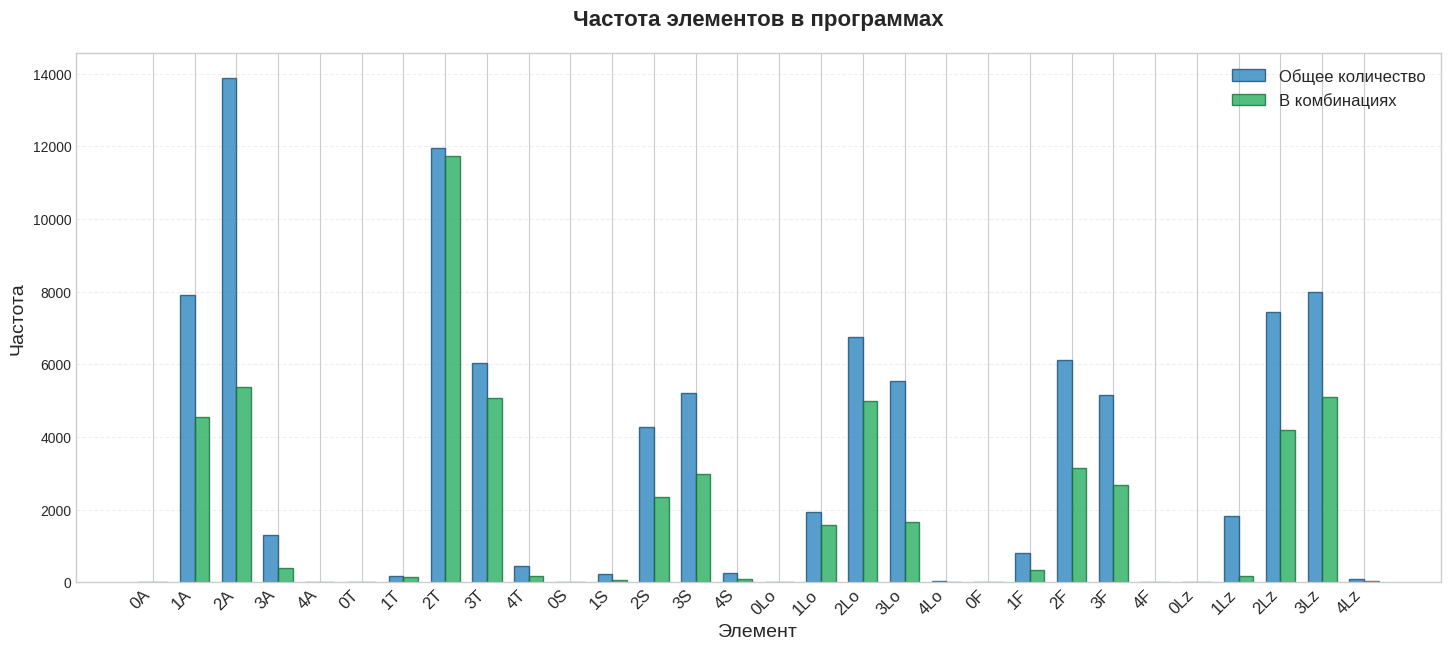

In [50]:
# Настройка параметров графика
plt.style.use('seaborn-v0_8-whitegrid')  # Стиль для лучшей визуализации
bar_width = 0.35  # Оптимизированная ширина столбцов
x = np.arange(len(updated_table['element']))  # Используем numpy для индексации

# Создание фигуры с оптимизированным размером
plt.figure(figsize=(15, 7))

# Создание групповых столбцов
# Общее количество выполнений
plt.bar(x, updated_table['total_executions'],
        width=bar_width,
        label='Общее количество',
        color='#2E86C1',  # Глубокий синий
        alpha=0.8,  # Прозрачность для лучшей видимости
        edgecolor='#1B4F72')  # Темный край

# Количество выполнений в комбинациях
plt.bar(x + bar_width, updated_table['combination_executions'],
        width=bar_width,
        label='В комбинациях',
        color='#27AE60',  # Яркий зеленый
        alpha=0.8,
        edgecolor='#196F3D')

# Настройка оформления
plt.title('Частота элементов в программах',
          fontsize=16,
          pad=20,  # Отступ от заголовка
          fontweight='bold')

plt.xlabel('Элемент', fontsize=14)
plt.ylabel('Частота', fontsize=14)

# Улучшенная настройка меток оси X
plt.xticks(x + bar_width/2,
           updated_table['element'],
           rotation=45,
           ha='right',  # Горизонтальное выравнивание вправо
           fontsize=12)

# Улучшение легенды
plt.legend(fontsize=12,
           loc='upper right',  # Позиция легенды
           framealpha=0.9,  # Прозрачность фона легенды
           edgecolor='#FFFFFF')

# Добавление сетки
plt.grid(True,
         axis='y',  # Только вертикальные линии
         linestyle='--',  # Пунктирные линии
         alpha=0.3)  # Прозрачность сетки

# Оптимизация отступов
plt.tight_layout(pad=2.5)

# Отображение графика
plt.show()

Из графика видно:
- Чем сложнее элемент, тем реже его комбинируют с другими прыжками
- Тулуп, практически всегда комбинируют с другим прыжками
- Больше половины акселей исполняются, как одиночный элемент

## Зависимость оценок от соревнований

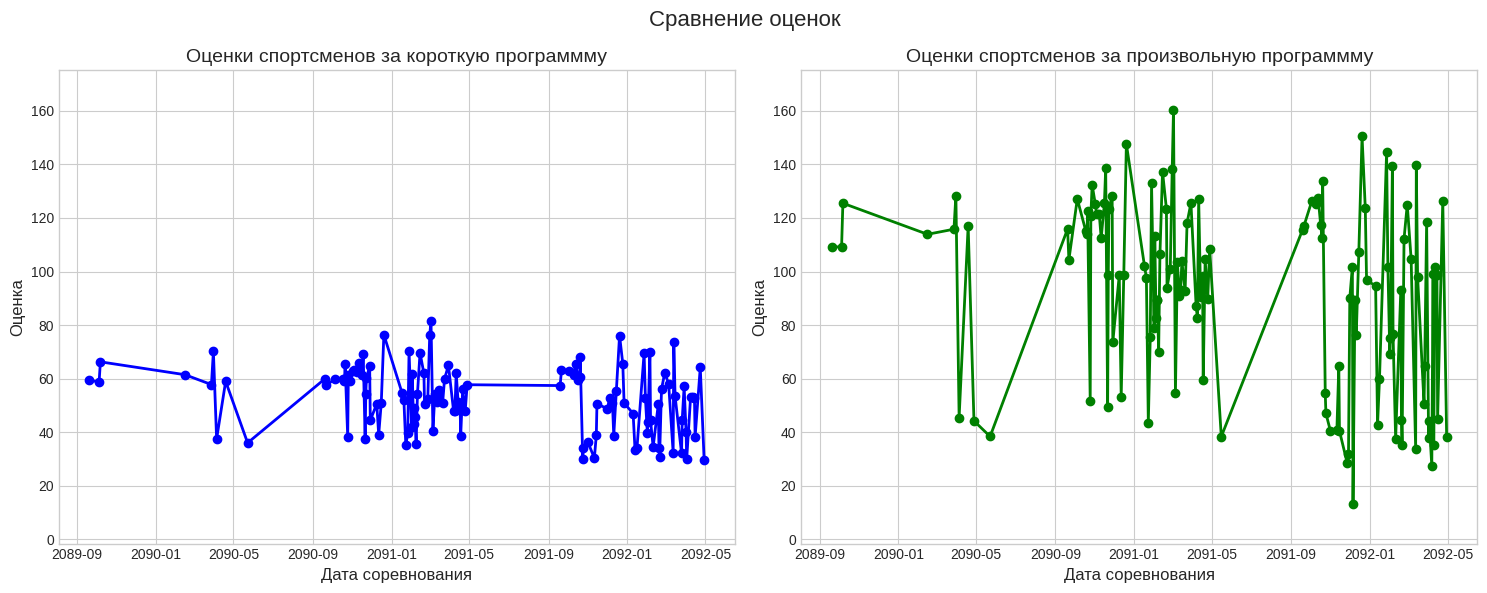

In [51]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Сравнение оценок', fontsize=16)

# Короткая программа
temp_short = (df[df['segment_name'] == 'Короткая программа']
              .groupby('date_start')['total_score'].agg('median'))
axes[0].plot(temp_short.index, temp_short.values, marker='o',
             linestyle='-', color='blue', linewidth=2)
axes[0].set_title('Оценки спортсменов за короткую программму', fontsize=14)
axes[0].set_xlabel('Дата соревнования', fontsize=12)
axes[0].set_ylabel('Оценка', fontsize=12)

# Произвольная программа
temp_free = (df[df['segment_name'] == 'Произвольная программа']
             .groupby('date_start')['total_score'].agg('median'))
axes[1].plot(temp_free.index, temp_free.values, marker='o',
             linestyle='-', color='green', linewidth=2)
axes[1].set_title('Оценки спортсменов за произвольную программму', fontsize=14)
axes[1].set_xlabel('Дата соревнования', fontsize=12)
axes[1].set_ylabel('Оценка', fontsize=12)

# Настройка общей шкалы
max_y = max(temp_short.max(), temp_free.max())
min_y = min(temp_short.min(), temp_free.min())
margin = (max_y - min_y) * 0.1
for ax in axes:
    ax.set_ylim(min_y - margin, max_y + margin)

plt.tight_layout()
plt.show()

Из графика, можно наблюдать, достаточно сильный разброс оценок между соревнованиям. Можно предположить, что в данных представлены соревнования разного уровня.

Проверим теорию, что уровень соревнований зависит от категории.

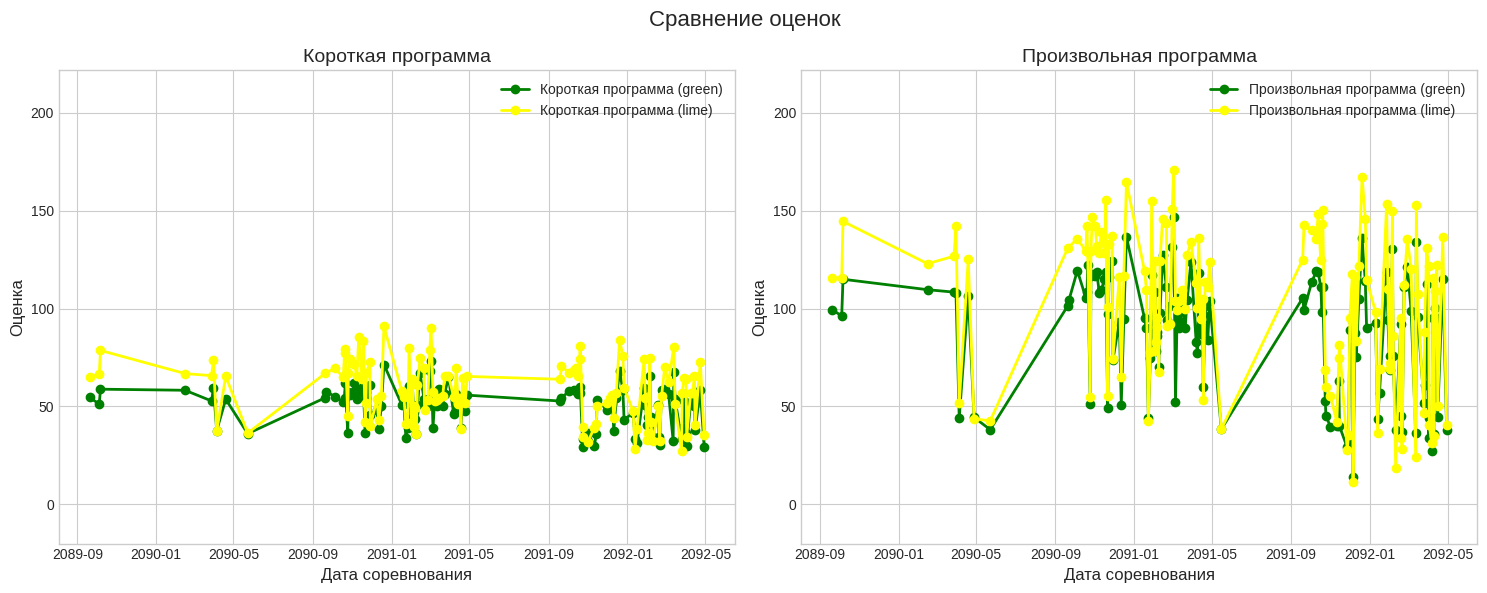

In [52]:
plt.rcParams['path.simplify'] = True
plt.rcParams['path.simplify_threshold'] = 1.0

# Создание фигуры с двумя подграфиками
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Сравнение оценок', fontsize=16)

# Оптимизированная функция для построения графиков
def plot_scores(ax, segment_name, color_name, color):
    temp = (df[(df['segment_name'] == segment_name) &
               (df['color'] == color_name)]
            .groupby('date_start')['total_score']
            .agg('median'))
    ax.plot(temp.index, temp.values, marker='o', linestyle='-',
            color=color, linewidth=2, label=f'{segment_name} ({color_name})')
    ax.legend(fontsize=10)
    ax.set_title(segment_name, fontsize=14)
    ax.set_xlabel('Дата соревнования', fontsize=12)
    ax.set_ylabel('Оценка', fontsize=12)

# Построение графиков для короткой программы
plot_scores(axes[0], 'Короткая программа', 'green', 'green')
plot_scores(axes[0], 'Короткая программа', 'lime', 'yellow')

# Построение графиков для произвольной программы
plot_scores(axes[1], 'Произвольная программа', 'green', 'green')
plot_scores(axes[1], 'Произвольная программа', 'lime', 'yellow')

# Оптимизация осей
max_y = df['total_score'].max()
min_y = df['total_score'].min()
margin = (max_y - min_y) * 0.1

for ax in axes:
    ax.set_ylim(min_y - margin, max_y + margin)

plt.tight_layout()
plt.show()

# Освобождение памяти
plt.clf()
plt.close()

Теория, что уровень соревнований зависит от категории, указанной в наших данных не подтвердилась. Но в данных явно прослеживаются соревнования где медианная оценка ниже.

## Зависимость даты соревнований от числа участников

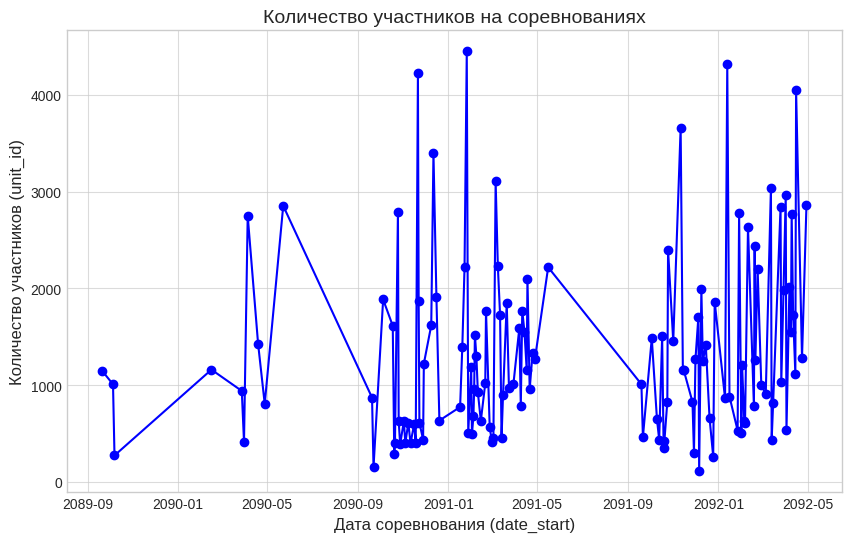

In [53]:
temp = df.groupby('date_start')['unit_id'].agg('count')

plt.figure(figsize=(10, 6))
plt.plot(temp, marker='o', linestyle='-', color='b')

# Добавление подписей
plt.title('Количество участников на соревнованиях', fontsize=14)
plt.xlabel('Дата соревнования (date_start)', fontsize=12)
plt.ylabel('Количество участников (unit_id)', fontsize=12)

# Добавление сетки
plt.grid(True,
         alpha=0.7,
         which='both')

plt.show()

Из графиков зависимости количества участников соревнований от даты соревнования и зависимости медианной оценки от даты соревнований прослеживается корреляция.

Построим график зависимости количества участников соревнований от средней оценки

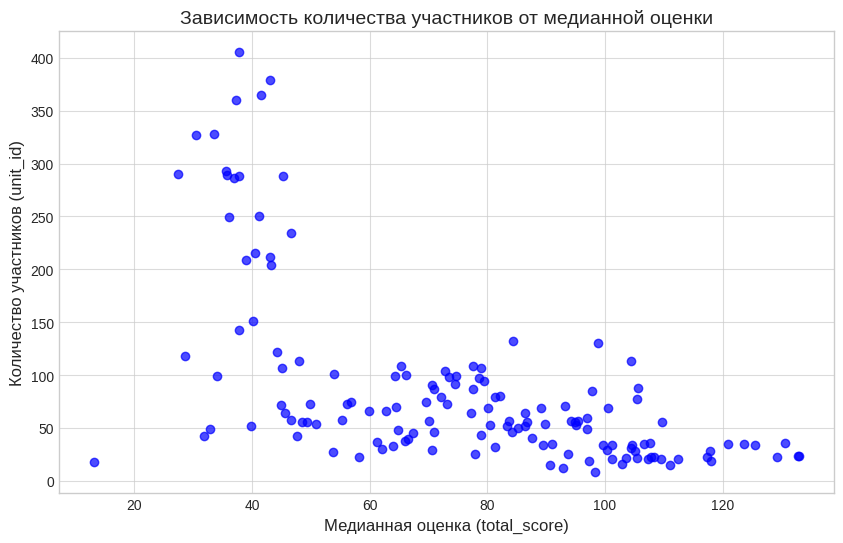

In [54]:
# Группировка данных для подсчета количества участников и медианной оценки
temp = df.groupby('tournament_id').agg(
    participants=('unit_id', 'nunique'),  # Количество участников
    median_score=('total_score', 'median')  # Медианная оценка
)

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(temp['median_score'], temp['participants'], color='b', alpha=0.7)

# Добавление подписей
plt.title('Зависимость количества участников от медианной оценки', fontsize=14)
plt.xlabel('Медианная оценка (total_score)', fontsize=12)
plt.ylabel('Количество участников (unit_id)', fontsize=12)

# Добавление сетки
plt.grid(True, alpha=0.7)

plt.show()

Прослеживается тренд, чем больше участников турнира, тем меньше медианный балл. Это может быть связано с тем, что:
- Турниры где много участников, являются 'проходными'. Например, для получения разряда в спорте. И спортсмены не выкладываются в полную силу.
- Может быть связано с форматом соревнований. Например, в некоторых юниорских или региональных турнирах, упрощают программу для экономии времени или для оценки только определенных навыков спортсменов. И тогда меньший бал объясним более легкой программой.
- Либо с увеличением числа спортсменов падает и уровень катания. На один хороший прокат, приходится 3-4 проката с падениями.

In [55]:
# Сгрупируем данные по программам
df.groupby(['color', 'segment_name'])['tournament_id'].agg('count')

color  segment_name          
green  Интерпретация               123
       Короткая программа        38351
       Произвольная программа    82010
       Прыжки                      663
       Элементы                   2495
lime   Короткая программа        17036
       Произвольная программа    29882
       Прыжки                      189
       Элементы                   1366
Name: tournament_id, dtype: int64

Видим, что чаще всего исполняют произвольную программу.

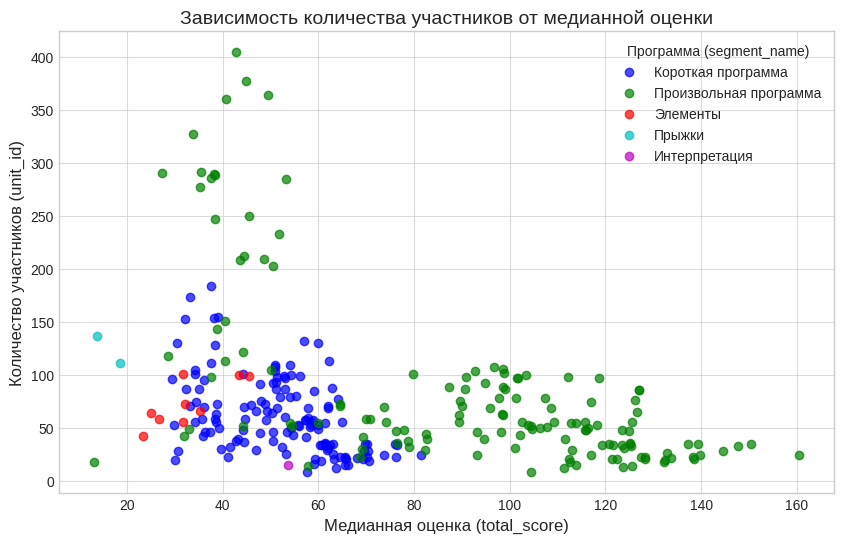

In [56]:
# Группировка данных для подсчета количества участников и медианной оценки
temp = df.groupby(['tournament_id', 'segment_name']).agg(
    participants=('unit_id', 'nunique'),  # Количество уникальных участников
    median_score=('total_score', 'median')  # Медианная оценка
).reset_index()

# Построение графика
plt.figure(figsize=(10, 6))

# Уникальные значения segment_name для разбиения по цветам
segments = temp['segment_name'].unique()
colors = ['b', 'g', 'r', 'c', 'm', 'y']  # Цвета для разных программ

for segment, color in zip(segments, colors):
    segment_data = temp[temp['segment_name'] == segment]
    plt.scatter(segment_data['median_score'], segment_data['participants'],
                color=color, alpha=0.7, label=segment)

# Добавление подписей
plt.title('Зависимость количества участников от медианной оценки', fontsize=14)
plt.xlabel('Медианная оценка (total_score)', fontsize=12)
plt.ylabel('Количество участников (unit_id)', fontsize=12)

# Добавление легенды
plt.legend(title='Программа (segment_name)', fontsize=10)

# Добавление сетки
plt.grid(True, alpha=0.7)

plt.show()

# Обучение моделей

## 1.Предсказание итогового балла за прокат.

- Отберем все выступления
- Разобьем выступление на элементы
- Векторизуем данные
- С помощью косинусного сходства определим похожие выступления. На основе которых будем рассчитывать итоговый балл.


### Формирование ДС

In [57]:
# Список столбцов которые хотим видеть в новом ДС
list_column = ['id_total_scores', 'tournament_id', 'base_score_total_scores',	'components_score',	'total_score',	'elements_score', 'segment_name', 'info', 'overall_total_score', 'date_start']

In [58]:
# Создание нового ДС
df1 = pd.merge(result, df[list_column], left_on='id_total_scores', right_on='id_total_scores', how='left')

In [59]:
# Удаление дублей строк
df1 = df1.groupby('id_total_scores').first().reset_index()

In [60]:
df1.head(3)

,id_total_scores,unit_id,performance_dict,tournament_id,base_score_total_scores,components_score,total_score,elements_score,segment_name,info,overall_total_score,date_start
0,1,1,"[{'element': '2A', 'base_score': 3.3, 'goe': 0...",1,31.99,24.67,56.86,33.19,Короткая программа,x Надбавка за прыжки во второй половине програ...,164.44,2090-11-29
1,8,1,"[{'element': '2A', 'base_score': 3.3, 'goe': 0...",1,57.30,49.40,107.58,58.18,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный ...,164.44,2090-11-29
2,19,1426,"[{'element': '2A', 'base_score': 3.3, 'goe': 0...",1,32.01,28.66,67.35,38.69,Короткая программа,x Надбавка за прыжки во второй половине програ...,201.45,2090-11-29


In [61]:
# Проверим, что количество строк в новом ДС совпадает с количеством уникальных выступлений
len(df['id_total_scores'].unique()), df1.shape[0]

(21301, 21301)

In [62]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>join_elements(...):
def join_elements(performance_dict):
    """
    Объединяет элементы из словаря в одну строку через '+'
    Пример: [{'element': '2A', ...}, {'element': '3F', ...}] -> '2A+3F'
    """
    return '+'.join(item['element'] for item in performance_dict)

In [63]:
# Добавление признака с элементами
df1['elements'] = df1['performance_dict'].apply(join_elements)

In [64]:
df1.head(3)

,id_total_scores,unit_id,performance_dict,tournament_id,base_score_total_scores,components_score,total_score,elements_score,segment_name,info,overall_total_score,date_start,elements
0,1,1,"[{'element': '2A', 'base_score': 3.3, 'goe': 0...",1,31.99,24.67,56.86,33.19,Короткая программа,x Надбавка за прыжки во второй половине програ...,164.44,2090-11-29,2A+3F+3Lo+3Lz+CCoSp4+FCSp4+LSp4+StSq2
1,8,1,"[{'element': '2A', 'base_score': 3.3, 'goe': 0...",1,57.30,49.40,107.58,58.18,Произвольная программа,q Прыжок приземлён в четверть < Недокрученный ...,164.44,2090-11-29,2A+3F+3Fq+3Loq+3Lz<+1Eu+2F+3Lzq+2T+3S+CCoSp4+C...
2,19,1426,"[{'element': '2A', 'base_score': 3.3, 'goe': 0...",1,32.01,28.66,67.35,38.69,Короткая программа,x Надбавка за прыжки во второй половине програ...,201.45,2090-11-29,2A+3Lo+3Lz+3T+CCoSp4+FCSp4+LSp4+StSq3


In [65]:
# Анализ пропусков
missing_values(df1)

,column_name,missing_count,percent_missing
0,id_total_scores,0,0
1,unit_id,0,0
2,performance_dict,0,0
3,tournament_id,0,0
4,base_score_total_scores,0,0
5,components_score,0,0
6,total_score,0,0
7,elements_score,0,0
8,date_start,0,0
9,elements,0,0


Проанализируем графически результаты одного спортсмена на разных соревнованиях.

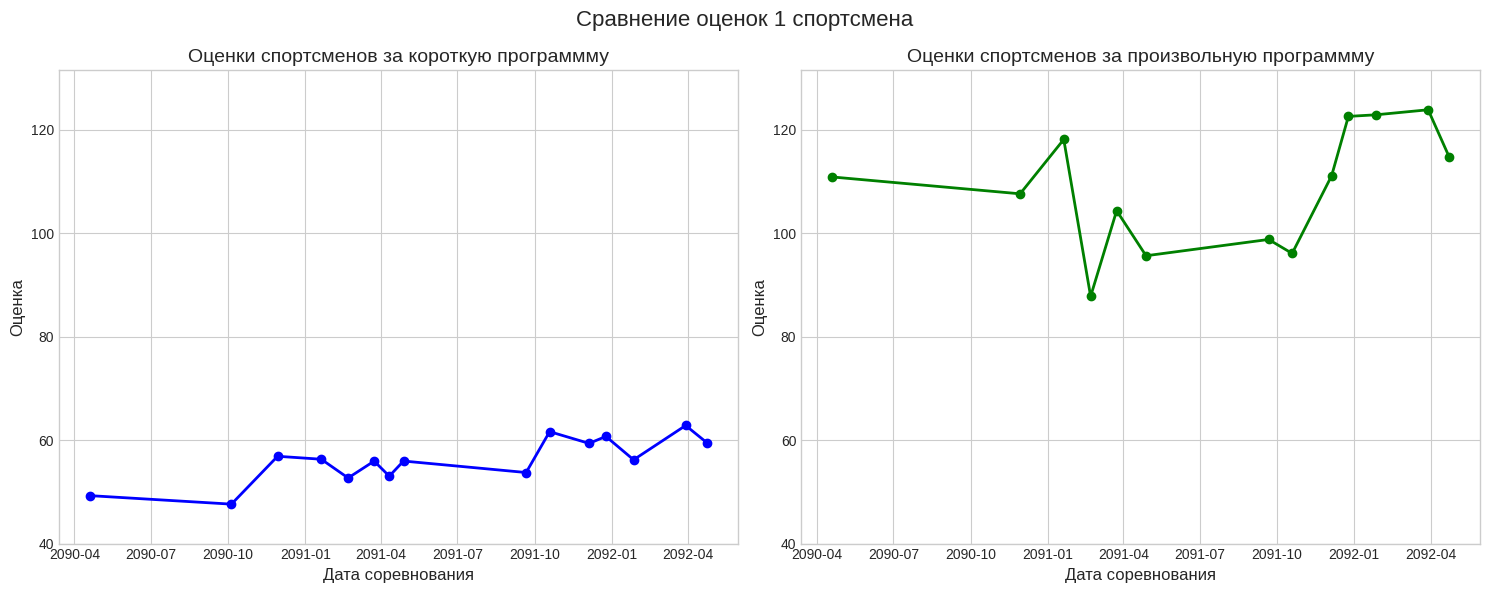

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Сравнение оценок 1 спортсмена', fontsize=16)

# Короткая программа
temp_short = (df1[(df1['segment_name'] == 'Короткая программа') & (df1['unit_id'] == 1)]
              .groupby('date_start')['total_score'].agg('median'))
axes[0].plot(temp_short.index, temp_short.values, marker='o',
             linestyle='-', color='blue', linewidth=2)
axes[0].set_title('Оценки спортсменов за короткую программму', fontsize=14)
axes[0].set_xlabel('Дата соревнования', fontsize=12)
axes[0].set_ylabel('Оценка', fontsize=12)

# Произвольная программа
temp_free = (df1[(df1['segment_name'] == 'Произвольная программа') & (df1['unit_id'] == 1)]
             .groupby('date_start')['total_score'].agg('median'))
axes[1].plot(temp_free.index, temp_free.values, marker='o',
             linestyle='-', color='green', linewidth=2)
axes[1].set_title('Оценки спортсменов за произвольную программму', fontsize=14)
axes[1].set_xlabel('Дата соревнования', fontsize=12)
axes[1].set_ylabel('Оценка', fontsize=12)

# Настройка общей шкалы
max_y = max(temp_short.max(), temp_free.max())
min_y = min(temp_short.min(), temp_free.min())
margin = (max_y - min_y) * 0.1
for ax in axes:
    ax.set_ylim(min_y - margin, max_y + margin)

plt.tight_layout()
plt.show()

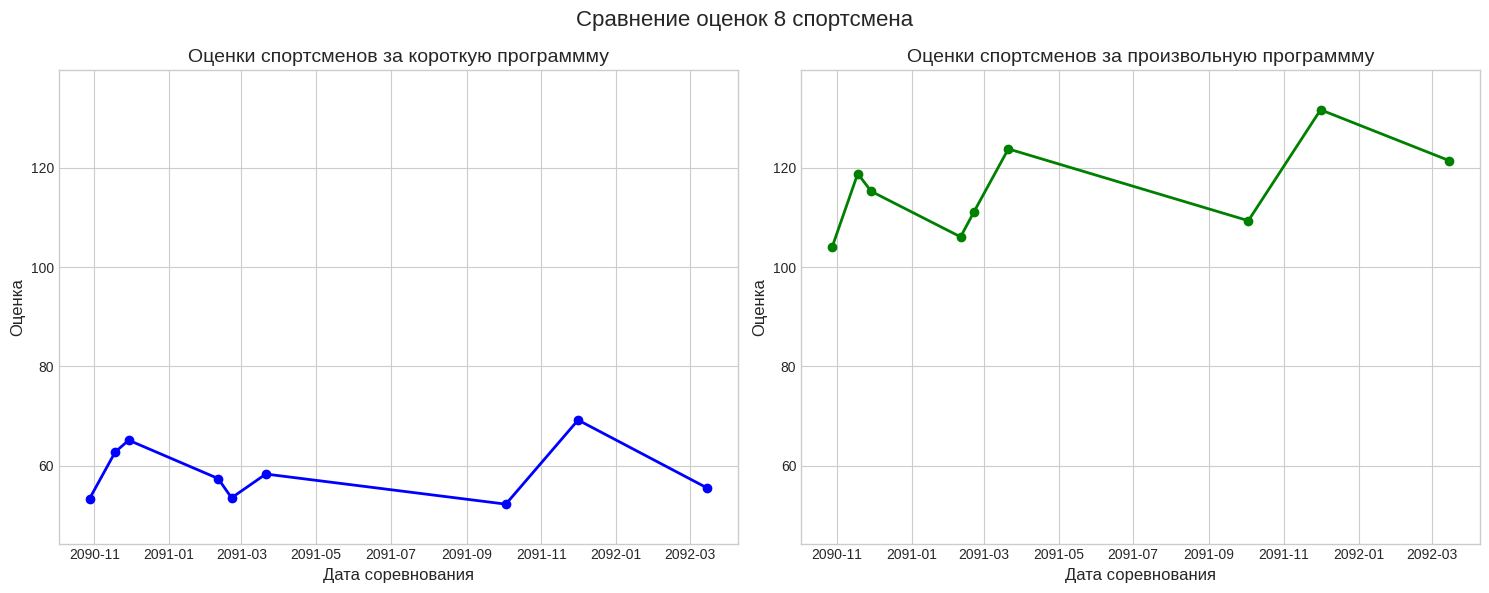

In [67]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Сравнение оценок 8 спортсмена', fontsize=16)

# Короткая программа
temp_short = (df1[(df1['segment_name'] == 'Короткая программа') & (df1['unit_id'] == 8)]
              .groupby('date_start')['total_score'].agg('median'))
axes[0].plot(temp_short.index, temp_short.values, marker='o',
             linestyle='-', color='blue', linewidth=2)
axes[0].set_title('Оценки спортсменов за короткую программму', fontsize=14)
axes[0].set_xlabel('Дата соревнования', fontsize=12)
axes[0].set_ylabel('Оценка', fontsize=12)

# Произвольная программа
temp_free = (df1[(df1['segment_name'] == 'Произвольная программа') & (df1['unit_id'] == 8)]
             .groupby('date_start')['total_score'].agg('median'))
axes[1].plot(temp_free.index, temp_free.values, marker='o',
             linestyle='-', color='green', linewidth=2)
axes[1].set_title('Оценки спортсменов за произвольную программму', fontsize=14)
axes[1].set_xlabel('Дата соревнования', fontsize=12)
axes[1].set_ylabel('Оценка', fontsize=12)

# Настройка общей шкалы
max_y = max(temp_short.max(), temp_free.max())
min_y = min(temp_short.min(), temp_free.min())
margin = (max_y - min_y) * 0.1
for ax in axes:
    ax.set_ylim(min_y - margin, max_y + margin)

plt.tight_layout()
plt.show()

Также наблюдается восходящий тренд. Спортсмен улучшает свои результаты, но и так же подтверждается теория с 'проходными' или межсезонными соревнованиями, где спортсмен не выкладывается в полную силу.

### Разбиваем на train и test

In [68]:
# Отобрали для теста последнее соревнование
df1_test = df1[df1['date_start'] == df1['date_start'].max()]

In [69]:
# y_true
df1_y_true_test = df1_test['total_score']

In [70]:
# Колонки для предсказания
column_pred = ['id_total_scores', 'unit_id', 'tournament_id',
       'segment_name', 'date_start', 'elements']

In [71]:
# ДС для предсказания
df1_test = df1_test[column_pred]

In [72]:
# ДС для обучения
df1_train = df1[~df1.index.isin(df1_test.index)]

In [73]:
df1.shape[0], df1_train.shape[0], df1_test.shape[0]

(21301, 20907, 394)

### Обучение модели

In [74]:
# Векторизация элементов выступления
vectorizer = TfidfVectorizer()
feature_matrix = vectorizer.fit_transform(df1_train['elements'])

In [75]:
# Вычисляем косинусное сходство между тестовым и тренировочным наборами
test_features = vectorizer.transform(df1_test['elements'])
similarity_matrix_test_train = cosine_similarity(test_features, feature_matrix)

In [76]:
# Прогнозирование total_score
predicted_scores = []
k = 15  # Количество ближайших соседей

for i in range(similarity_matrix_test_train.shape[0]):
    # Получаем индексы k наиболее похожих соревнований
    top_k_indices = np.argsort(similarity_matrix_test_train[i])[-k:]

    # Медианное значение total_score для этих соревнований
    top_k_scores = df1_train.iloc[top_k_indices]['total_score']
    predicted_score = top_k_scores.median()
    predicted_scores.append(predicted_score)

# Добавляем предсказания в тестовый набор
df1_test['predicted_total_score'] = predicted_scores

### Тестирование модели

In [77]:
mse = mean_squared_error(df1_y_true_test, df1_test['predicted_total_score'])

# Вычисление RMSE вручную
rmse = np.sqrt(mse)
print(f"RMSE: {rmse:.2f}")

RMSE: 4.27


In [78]:
df1_test['true_total_score'] = df1_y_true_test

In [79]:
df1_test.head(2)

,id_total_scores,unit_id,tournament_id,segment_name,date_start,elements,predicted_total_score,true_total_score
20907,463246,2887,7117,Произвольная программа,2092-04-29,ChSpl1+1Lz+SSpB+1A+1Lo+1A+CSpB,17.42,20.61
20908,463247,2889,7117,Произвольная программа,2092-04-29,1Lz+SSpB+ChSpl1+1A+1Lo+CSpB+1A,17.42,17.62


## 2.Мониторинг результатов спортсмена

Создадим систему мониторинга результатов, которая поможет тренеру эффективно планировать дальнейшее развитие спортсмена и улучшение его навыков.

- Отберем спортсменов, которые участвовали в более чем 4 турнирах, чтобы работать с достаточным объемом данных для анализа.
- При планировании программы выступления, будет выдаваться информация по спортсмену, сколько раз спортсмен выполнил данный элемент программы на турнире, сколько раз исполнил его чисто и сколько раз допустил ошибку.


In [80]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>filter_elements_combo(...):
def filter_elements_combo(elements):
    '''Фильтруем элементы, которые выполнялись в комбинации'''
    return [element for element in elements if '+' in element]

In [81]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>filter_elements_solo(...):
def filter_elements_solo(elements):
    '''Фильтруем элементы, которые выполнялись соло'''
    return [element for element in elements if '+' not in element]

In [82]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>bad_elements(...):
def bad_elements(element_str):
    """
    Извлекает элементы, выполненные с ошибкой.
    Пример: [3F, 3Lo, 3Fq, 3Loq, 3Lz<, 1Eu, 2F, 3Lzq, 2T] ->
            [3Fq, 3Loq, 3Lz<, 3Lzq]
    """

    drop_symbols = ['<', '<<', '*', 'e', '!', 'q',
                    '<*', '<<*', 'q*', '!*', 'e*',
                    '!<', '!<*', '!<<', '!<<*', '!q'
                    ]

    element_list = []
    for el in element_str:
        for symbol in drop_symbols:
            # Проверяем, находится ли символ в конце строки
            if el.endswith(symbol):
                element_list.append(el.split(symbol)[0])
    return element_list

In [83]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>good_elements(...):
def good_elements(element_str):
    """
    Извлекает элементы выполненые без ошибки
    Пример: [3F, 3Lo, 3Fq, 3Loq, 3Lz<, 1Eu, 2F, 3Lzq, 2T] ->
            [3F, 3Lo, 3Loq, 1Eu, 2F, 2T]
    """
    drop_symbols = ['<', '<<', '*', 'e', '!', 'q',
                    '<*', '<<*', 'q*', '!*', 'e*',
                    '!<', '!<*', '!<<', '!<<*', '!q'
                    ]

    element_list = []
    for el in element_str:
        # Проверяем, что ни один из символов ошибок не находится в конце строки
        if not any(el.endswith(symbol) for symbol in drop_symbols):
            element_list.append(el)
    return element_list

### Формирование ДС

In [84]:
# Считаем, что на одном турнире спортсмен находится в одинаковой физической форме
# Сгрупирую данные по спортсмену и номеру турнира
# Составим список уникальных элементов выполненных на этом турнире

df2 = df.groupby(['unit_id', 'tournament_id'], as_index=False).title.agg('unique')

In [85]:
df2.head(1)

,unit_id,tournament_id,title
0,1,1,"[2A, 3F+3Lo, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, ..."


In [86]:
# Создаем список элементов из комбинаций прыжков
df2['combo_elements'] = df2['title'].apply(filter_elements_combo)

In [87]:
# Создаем список элементов из сольных прыжков
df2['solo_elements'] = df2['title'].apply(filter_elements_solo)

In [88]:
# Разделим элементы прыжков на элементы
df2['combo_elements'] = df2['combo_elements'].apply(lambda x: '+'.join(x).split('+'))

In [89]:
# Создаем список элементов выполненых с ошибкой соло
df2['solo_bad_elements'] = df2['solo_elements'].apply(bad_elements)

In [90]:
# Создаем список элементов выполненых с ошибкой в комбинации
df2['combo_bad_elements'] = df2['combo_elements'].apply(bad_elements)

In [91]:
# Создаем общий список элементов выполненых с ошибкой
df2['bad_elements'] = df2['solo_bad_elements'] + df2['combo_bad_elements']

In [92]:
# Создаем список элементов выполненых без ошибок соло
df2['solo_good_elements'] = df2['solo_elements'].apply(good_elements)

In [93]:
# Создаем список элементов выполненых без ошибок комбо
df2['combo_good_elements'] = df2['combo_elements'].apply(good_elements)

In [94]:
# Создаем общий список элементов выполненых без ошибок
df2['good_elements'] = df2['solo_good_elements'] + df2['combo_good_elements']

In [95]:
# Создаем общий список элементов выполненых без ошибок
df2['all_elements'] = df2['good_elements'] + df2['bad_elements']

In [96]:
# Добавим столбец с датой соревнований
df2 = pd.merge(df2, df_tournaments[['id', 'date_start']], left_on='tournament_id', right_on='id', how='left')
df2 = df2.drop(columns=['id'])

In [97]:
# Меняем тип данных на datetime
df2['date_start'] = pd.to_datetime(df2['date_start'])

In [98]:
df2.head(2)

,unit_id,tournament_id,title,combo_elements,solo_elements,solo_bad_elements,combo_bad_elements,bad_elements,solo_good_elements,combo_good_elements,good_elements,all_elements,date_start
0,1,1,"[2A, 3F+3Lo, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, ...","[3F, 3Lo, 3Fq, 3Loq, 3Lz<, 1Eu, 2F, 3Lzq, 2T]","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...",[],"[3F, 3Lo, 3Lz, 3Lz]","[3F, 3Lo, 3Lz, 3Lz]","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...","[3F, 3Lo, 1Eu, 2F, 2T]","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...",2090-11-29
1,1,3,"[2A, 3F+2Lo, FCSp3, StSq1, 2Lz<<, CCoSp2, LSp4]","[3F, 2Lo]","[2A, FCSp3, StSq1, 2Lz<<, CCoSp2, LSp4]","[2Lz, 2Lz]",[],"[2Lz, 2Lz]","[2A, FCSp3, StSq1, CCoSp2, LSp4]","[3F, 2Lo]","[2A, FCSp3, StSq1, CCoSp2, LSp4, 3F, 2Lo]","[2A, FCSp3, StSq1, CCoSp2, LSp4, 3F, 2Lo, 2Lz,...",2090-10-05


In [99]:
# Сделаем копию ДС
df_elements = df2.copy()

In [100]:
# Оставим только тех спортсменов, кто есть в списке unit_id_more_4
print('Количество строк до удаления',df2.shape)
df2 = df2[df2['unit_id'].isin(unit_id_more_4)]
print('Количество строк после удаления',df2.shape)

Количество строк до удаления (12555, 13)
Количество строк после удаления (7678, 13)


### Разбиваем на train и test

Для тестовой выборки отберем последние выступление спртсмена.

In [101]:
# Группируем по 'unit_id' и находим индекс строки с максимальной датой для каждого спортсмена
max_date_indices = df2.groupby('unit_id')['date_start'].idxmax()

In [102]:
# Отобрали для теста последнее соревнование
df2_test = df2.loc[max_date_indices]

In [103]:
# ДС для обучения
df2_train= df2.drop(max_date_indices)

In [104]:
df2.shape[0], df2_train.shape[0], df2_test.shape[0]

(7678, 6736, 942)

### Обучение модели

In [105]:
# Превращаем набор элементов в строку
df2_train['bad_elements'] = df2_train['bad_elements'].apply(lambda x: ', '.join(x))
df2_test['bad_elements'] = df2_test['bad_elements'].apply(lambda x: ', '.join(x))
df2_train['all_elements'] = df2_train['all_elements'].apply(lambda x: ', '.join(x))
df2_test['all_elements'] = df2_test['all_elements'].apply(lambda x: ', '.join(x))
df2_train['good_elements'] = df2_train['good_elements'].apply(lambda x: ', '.join(x))
df2_test['good_elements'] = df2_test['good_elements'].apply(lambda x: ', '.join(x))

In [106]:
# Векторизация элементов выступления
vectorizer2 = CountVectorizer(tokenizer=lambda x: x.split(', '))
feature_matrix2 = vectorizer2.fit_transform(df2_train['all_elements'])

In [107]:
feature_df2 = pd.DataFrame(
    feature_matrix2.toarray(),
    index=df2_train.index,  # Сохраняем оригинальные индексы
    columns=vectorizer2.get_feature_names_out()
)

In [108]:
feature_df2['unit_id'] = df2_train['unit_id']

In [109]:
feature_df2['all_elements'] = df2_train['all_elements']
feature_df2['bad_elements'] = df2_train['bad_elements']
feature_df2['good_elements'] = df2_train['good_elements']


In [110]:
# Вычисляем косинусное сходство между тестовым и тренировочным наборами
test_features2 = vectorizer2.transform(df2_test['bad_elements'])
similarity_similarity_matrix = cosine_similarity(test_features2, feature_matrix2)
similarity_similarity_matrix = pd.DataFrame(similarity_similarity_matrix, index=df2_test.index, columns=df2_train.index)

In [111]:
similarity_similarity_matrix.shape


(942, 6736)

In [112]:
feature_df2.head(1)

,,1a,1a<,1a<<,1eu,1f,1f!,1lo,1lo<,1lo<<,1lz,1lz!,1lze,1s,1t,1t<,1t<<,2a,2a<,2a<<,2aq,2f,2f!,2f!<,2f!<<,2f<,2f<<,2fe,2fq,2lo,2lo<,2lo<<,2loq,2lz,2lz!,2lz!q,2lz<,2lz<<,2lze,2lzq,2s,2s<,2s<<,2sq,2t,2t<,2t<<,2tq,3a,3a<,3a<<,3aq,3f,3f!,3f!<,3f<,3f<<,3fe,3fq,3lo,3lo<,3lo<<,3loq,3lz,3lz!,3lz!<,3lz!q,3lz<,3lz<<,3lze,3lze<,3lzq,3s,3s*,3s<,3s<<,3sq,3t,3t<,3t<<,3tq,4f,4f!,4lo,4lz,4lz!,4lz<,4lz<<,4s,4s<,4s<<,4sq,4t,4t<,4t<<,4tq,a,ccosp,ccosp1,ccosp1v,ccosp2,ccosp2v,ccosp3,ccosp3v,ccosp4,ccosp4v,ccospb,ccospbv,ccospv,ccsp,ccsp1,ccsp1v,ccsp2,ccsp2v,ccsp3,ccsp3v,ccsp4,ccspb,chs,chspl,chspl1,chsq1,combo,cosp,cosp1,cosp1v,cosp2v,cospb,cospbv,csp,csp1,csp2,csp3,csp4,cspb,cssp,cssp1,cssp1v,cssp2,cssp2v,cssp3,cssp3v,cssp4,cssp4v,csspb,csspbv,f,fccosp,fccosp1,fccosp1v,fccosp2,fccosp2v,fccosp3,fccosp3v,fccosp4,fccosp4v,fccospb,fccospbv,fccsp4,fcosp,fcosp2v,fcsp,fcsp1,fcsp2,fcsp3,fcsp4,fcspb,fcssp1,fcssp1v,fcssp2,fcssp2v,fcssp3,fcssp3v,fcssp4,fcsspb,fcsspbv,flsp3,flsp4,fssp,fssp1,fssp1v,fssp2,fssp2v,fssp3,fssp3v,fssp4,fssp4v,fsspb,lo,lsp,lsp1,lsp2,lsp3,lsp4,lspb,lz,rep,s,seq,sp,ssp,ssp1,ssp2,ssp3,ssp4,sspb,sts,stsq1,stsq2,stsq3,stsq4,stsqb,t,uspb,unit_id,all_elements,bad_elements,good_elements
0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,3,0,0,0,0,0,0,2,0,0,0,3,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,"2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, C...","3F, 3Lo, 3Lz, 3Lz","2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, C..."


In [113]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>predict_risky_elements(...):
def predict_risky_elements(unit_id, elements_to_perform,
                           similarity_matrix, feature_df2,
                           vectorizer, threshold=0.8, min_frequency=2):
    """
    Предсказывает рискованные элементы для конкретного спортсмена,
    учитывая как все элементы, так и ошибочные.

    Args:
        unit_id (int): ID спортсмена.
        elements_to_perform (list): Список элементов для выполнения.
        similarity_matrix (array): Матрица сходства.
        feature_df2 (DataFrame): DataFrame с признаками.
        vectorizer (CountVectorizer): Векторизатор.
        threshold (float): Пороговое значение сходства (0-1).
        min_frequency (int): Минимальное количество ошибок.

    Returns:
        list: Список кортежей (элемент, количество ошибок, количество попыток).
    """
    # Преобразуем элементы в строку
    elements_str = ', '.join(elements_to_perform)

    # Векторизуем выступление
    test_features = vectorizer.transform([elements_str])

    # Получаем индексы похожих выступлений
    similar_indices = np.where(similarity_matrix[unit_id] >= threshold)[0]

    # Создаем словари для подсчета частоты элементов
    element_errors = {}  # Количество ошибок для каждого элемента
    element_good = {}  # Количество хороших элементов
    element_totals = {}  # Общее количество выполнений каждого элемента

    for idx in similar_indices:
        unit_id_match = int(feature_df2.iloc[idx]['unit_id'])
        if unit_id_match == unit_id:  # Только для данного спортсмена
            # Учитываем как 'all_elements', так и 'bad_elements'
            all_elements = feature_df2.iloc[idx].get('all_elements', '')
            bad_elements = feature_df2.iloc[idx].get('bad_elements', '')
            good_elements = feature_df2.iloc[idx].get('good_elements', '')


            def safe_split(text):
                """Функция разделения текста с обработкой None и пустых значений"""
                return [] if text is None or not isinstance(text, str) else text.split(', ')

            # Разделяем элементы
            all_elements_list = safe_split(all_elements)
            bad_elements_list = safe_split(bad_elements)
            good_elements_list = safe_split(good_elements)


            # Подсчитываем общее количество выполнений элементов
            for elem in all_elements_list:
                element_totals[elem] = element_totals.get(elem, 0) + 1

            # Подсчитываем количество ошибок
            for elem in bad_elements_list:
                element_errors[elem] = element_errors.get(elem, 0) + 1

            # Подсчитываем верно исполненных элементов
            for elem in good_elements_list:
                element_good[elem] = element_good.get(elem, 0) + 1

    # Формируем список рискованных элементов
    risky_elements = []
    for elem in all_elements_list:
        total_count = element_totals.get(elem, 0)
        error_count = element_errors.get(elem, 0)
        good_count = element_good.get(elem, 0)

        # Учитываем только элементы с достаточным количеством ошибок
        if error_count >= min_frequency:
            risky_elements.append((elem, total_count,  error_count, good_count))

    # Сортируем по количеству ошибок в порядке убывания
    return sorted(risky_elements, key=lambda x: x[2], reverse=True)

In [114]:
# Пример использования функции
elements_to_perform = set(df2_test[df2_test['unit_id'] == 1]['all_elements'].iloc[0])
risky_elements = predict_risky_elements(
    1,
    elements_to_perform,
    similarity_similarity_matrix,
    feature_df2,
    vectorizer2,
    threshold=0,
    min_frequency=0
)
print("Рискованные элементы для спортсмена (элемент, количество ошибок, количество попыток):")
for element, total, errors, good_count in risky_elements:  # Unpack all four values
    print(f"{element}: {errors} ошибок, {good_count} верно из {total} попыток")
print('*' * 125)
print('Спортсмен ошибся в',df2_test[df2_test['unit_id'] == 1]['bad_elements'].iloc[0])

Рискованные элементы для спортсмена (элемент, количество ошибок, количество попыток):
3Lo: 15 ошибок, 5 верно из 20 попыток
3F: 14 ошибок, 21 верно из 35 попыток
3F: 14 ошибок, 21 верно из 35 попыток
3Lz: 12 ошибок, 22 верно из 34 попыток
3Lz: 12 ошибок, 22 верно из 34 попыток
3Lz: 12 ошибок, 22 верно из 34 попыток
3T: 6 ошибок, 5 верно из 11 попыток
2Lo: 4 ошибок, 10 верно из 14 попыток
2Lo: 4 ошибок, 10 верно из 14 попыток
2Lo: 4 ошибок, 10 верно из 14 попыток
2A: 1 ошибок, 18 верно из 19 попыток
2T: 1 ошибок, 8 верно из 9 попыток
2A: 1 ошибок, 18 верно из 19 попыток
LSp4: 0 ошибок, 10 верно из 10 попыток
FCSp4: 0 ошибок, 6 верно из 6 попыток
StSq3: 0 ошибок, 5 верно из 5 попыток
CCoSp4: 0 ошибок, 10 верно из 10 попыток
FCSp3: 0 ошибок, 11 верно из 11 попыток
ChSq1: 0 ошибок, 12 верно из 12 попыток
SEQ: 0 ошибок, 4 верно из 4 попыток
*****************************************************************************************************************************
Спортсмен ошибся в 3Lo, 3F

In [115]:
# Пример использования функции
elements_to_perform = set(df2_test[df2_test['unit_id'] == 8]['all_elements'].iloc[0])
risky_elements = predict_risky_elements(
    8,
    elements_to_perform,
    similarity_similarity_matrix,
    feature_df2,
    vectorizer2,
    threshold=0,
    min_frequency=0
)
print("Рискованные элементы для спортсмена (элемент, количество ошибок, количество попыток):")
for element, total, errors, good_count in risky_elements:  # Unpack all four values
    print(f"{element}: {errors} ошибок, {good_count} верно из {total} попыток")
print('*' * 125)
print('Спортсмен ошибся в',df2_test[df2_test['unit_id'] == 8]['bad_elements'].iloc[0])

Рискованные элементы для спортсмена (элемент, количество ошибок, количество попыток):
3Lz: 12 ошибок, 4 верно из 16 попыток
3Lz: 12 ошибок, 4 верно из 16 попыток
3Lz: 12 ошибок, 4 верно из 16 попыток
3Lo: 9 ошибок, 16 верно из 25 попыток
3F: 7 ошибок, 13 верно из 20 попыток
3F: 7 ошибок, 13 верно из 20 попыток
3T: 6 ошибок, 2 верно из 8 попыток
3S: 5 ошибок, 3 верно из 8 попыток
2A: 1 ошибок, 12 верно из 13 попыток
2A: 1 ошибок, 12 верно из 13 попыток
CCoSp4: 0 ошибок, 8 верно из 8 попыток
ChSq1: 0 ошибок, 8 верно из 8 попыток
StSq3: 0 ошибок, 6 верно из 6 попыток
FCCoSp4: 0 ошибок, 7 верно из 7 попыток
FCSp4: 0 ошибок, 2 верно из 2 попыток
CSp4: 0 ошибок, 7 верно из 7 попыток
FSSp4: 0 ошибок, 6 верно из 6 попыток
2T: 0 ошибок, 8 верно из 8 попыток
1Eu: 0 ошибок, 7 верно из 7 попыток
*****************************************************************************************************************************
Спортсмен ошибся в 3F, 3F, 3Lo, 3Lz, 3S


In [116]:
risky_elements

[('3Lz', 16, 12, 4),
 ('3Lz', 16, 12, 4),
 ('3Lz', 16, 12, 4),
 ('3Lo', 25, 9, 16),
 ('3F', 20, 7, 13),
 ('3F', 20, 7, 13),
 ('3T', 8, 6, 2),
 ('3S', 8, 5, 3),
 ('2A', 13, 1, 12),
 ('2A', 13, 1, 12),
 ('CCoSp4', 8, 0, 8),
 ('ChSq1', 8, 0, 8),
 ('StSq3', 6, 0, 6),
 ('FCCoSp4', 7, 0, 7),
 ('FCSp4', 2, 0, 2),
 ('CSp4', 7, 0, 7),
 ('FSSp4', 6, 0, 6),
 ('2T', 8, 0, 8),
 ('1Eu', 7, 0, 7)]

## 3.Рекомендательная система для изучения новых элементов

Будем считать, что если хоть на одном турнире у спортсмена получилось выполнить элемент чисто, то он его освоил.
- Объединим данные по id спортсмена.
- Выделим спортивные элементы, которые спортсмен выполнил чисто хотя бы один раз.

Создадим систему рекомендаций для изучения новых элементов, основываясь на анализе выступлений других фигуристов.
- С помощью косинусного сходства определим спортсменов с похожими наборами элементов.
- Выделим элементы, которые не выполнял текущий спортсмен, но которые успешно выполняли его соперники.
- В рекомендацию включим, как сольные прыжки так и комбинацию элементов.


In [117]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>filter_clean_elements(...):
def filter_clean_elements(row):
    ''' Функция, которая отбирает элементы которые выполнены без ошибок

    Регулярное выражение
    .*[\*\!\<] — проверяет, что строка не содержит символов *, !, <.
    *q(?!\d) .*e(?!\d))— проверяет, что строка не содержит q, e за которым не идет цифра.
    '''

    pattern = r"^(?!.*[\*\!\<]|.*q(?!\d)|.*e(?!\d)).*$"
    elements = row.split(", ")  # Разделяем строку на элементы
    filtered = [el for el in elements if re.match(pattern, el)]  # Применяем фильтр

    return ", ".join(filtered)  # Объединяем обратно в строку

In [118]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>find_top_k_neighbors(...):
# Функция для поиска ближайших соседей
def find_top_k_neighbors(similarity_matrix, unit_id, k=5):
    '''
    Находит индекси спортсменов похожего уровня


    Args:
        unit_id (int): ID спортсмена
        similarity_matrix (array): Матрица сходства между спортсменами
        k (int): Количество ближайших соседей для рассмотрения

    Returns:
        list: Список индексов индекси спортсменов похожего уровня
    '''

    # Находим индекс строки для указанного unit_id
    unit_index = df3[df3['unit_id'] == unit_id].index[0]

    # Получаем сходства для указанного unit_id
    similarities = similarity_matrix[unit_index]

    # Сортируем индексы по убыванию сходства
    sorted_indices = np.argsort(similarities)[::-1]

    # Исключаем самого себя из списка
    top_k_indices = [i for i in sorted_indices if i != unit_index][:k]

    # # Возвращаем DataFrame с ближайшими соседями
    # return df3.iloc[top_k_indices]

    return top_k_indices

In [119]:
# @title <font color='#3a8beb'>def <font color='#c4b856'>find_new_elements(...):
def find_new_elements(unit_id, similarity_matrix, feature_df3, k=5):
    '''
    Находит элементы, которые делают ближайшие соседи спортсмена,
    но не входят в его арсенал.

    Args:
        unit_id (int): ID спортсмена
        similarity_matrix (array): Матрица сходства между спортсменами
        feature_df3 (DataFrame): DataFrame с признаками элементов
        k (int): Количество ближайших соседей для рассмотрения

    Returns:
        list: Список элементов, которые делают соседи, но не входят в арсенал спортсмена
    '''
    # Находим индексы k ближайших соседей
    top_k_indices = find_top_k_neighbors(similarity_matrix, unit_id, k)

    idx = feature_df3.index.get_loc(unit_id)
    # Получаем элементы текущего спортсмена
    all_elements = feature_df3.iloc[idx]
    know_elements = all_elements[all_elements > 0].index.to_list()

    # Собираем все элементы, которые делают ближайшие соседи
    new_elements = []
    for neighbor_id in top_k_indices:
        neighbor_elements = feature_df3.iloc[neighbor_id]
        new_elements.extend(neighbor_elements[neighbor_elements > 0].index.to_list())

    # Возвращаем элементы, которых не знает текущий спортсмен
    return sorted(list(set([el for el in new_elements if el not in know_elements])))

In [120]:
#За основу возьму ДС с элементами полученый на прошлом шаге.
df3 = df_elements

In [121]:
df3.head(1)

,unit_id,tournament_id,title,combo_elements,solo_elements,solo_bad_elements,combo_bad_elements,bad_elements,solo_good_elements,combo_good_elements,good_elements,all_elements,date_start
0,1,1,"[2A, 3F+3Lo, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, ...","[3F, 3Lo, 3Fq, 3Loq, 3Lz<, 1Eu, 2F, 3Lzq, 2T]","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...",[],"[3F, 3Lo, 3Lz, 3Lz]","[3F, 3Lo, 3Lz, 3Lz]","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...","[3F, 3Lo, 1Eu, 2F, 2T]","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...","[2A, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3F, 3S, ...",2090-11-29


In [122]:
# разобьем на элементы
df3['title'] = df3['title'].apply(lambda x: ', '.join(x))

In [123]:
# Сгрупируем по спортсмену
df3 = df3.groupby('unit_id')['title'].agg(lambda x: ', '.join(x)).reset_index()

In [124]:
# Удаляем дублирующие элементы
df3['title_unique'] = df3['title'].apply(lambda x: ", ".join(set(x.split(", "))))

In [125]:
# Отбор элементов без ошибок
df3['clean_elements'] = df3['title_unique'].apply(filter_clean_elements)

In [126]:
df3.head()

,unit_id,title,title_unique,clean_elements
0,1,"2A, 3F+3Lo, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz<+1Eu+3S<<,...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz+1Eu+2F, 3S..."
1,3,"2A, 3F, 3Lz+3Lo, CCoSp3, FSSp4, LSp4, StSq3, 3...","3Lz+2Lo, StSq1, 3F, 1S, 2Aq, ChSq1, 3Lzq, 3Lo+...","3Lz+2Lo, StSq1, 3F, 1S, ChSq1, 3Lo+2Lo, 3S, 2A..."
2,4,"2A, 3Lo, 3T+2T, CCoSp3V, CSSp2, FCSp2, StSq3, ...","3T+1Eu<<+2S, ChSq1, FCCoSp2, FSSp1, 3Lo<<, 3S,...","ChSq1, FCCoSp2, FSSp1, 3S, 3T+2T, 2A, CCoSp2, ..."
3,5,"2A, 3Lo, 3Lz+2T, CCoSp4, FCSp4, LSp3, StSq3, 2...","1F+2A+2A<+SEQ, 3F, ChSq1, 1T, 3Lz+2A+2A+SEQ, 1...","3F, ChSq1, 1T, 3Lz+2A+2A+SEQ, 1Lz+2A+SEQ, LSp1..."
4,6,"2A, 3F+COMBO+2T*, 3Lo, CCoSp4, FCSp4, LSp4, St...","3F, ChSq1, 3F+3T, 3Lz!+3T, 2A+1Eu+3S, FSSp1, 2...","3F, ChSq1, 3F+3T, 2A+1Eu+3S, FSSp1, 2A+3T, 3S,..."


На примере одного спортсмена продемонстрирую как меняется список элементов

In [127]:
# Все элементы после групировки данных
df3['title'].apply(
    lambda x: ", ".join(sorted(x.split(", ")))
)[0]

'1Lz*, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A, 2A+2T, 2F, 2Lz<<, 3F, 3F, 3F, 3F, 3F, 3F, 3F!, 3F!, 3F!+2Lo, 3F!+2Lo<, 3F!<, 3F!q, 3F!q+3Lo<<, 3F+2A+2Lo<+SEQ, 3F+2Lo, 3F+2Lo, 3F+2Lo, 3F+2Lo, 3F+2Lo, 3F+2Lo, 3F+2Lo, 3F+3Lo, 3F+3Lo, 3F+3Lo<, 3F+3Lo<, 3F+3Lo<, 3F+3Lo<, 3F+3Lo<<, 3F+3Lo<<, 3F+3Loq, 3F<, 3F<<, 3Fq, 3Fq, 3Fq+1Eu+2F, 3Fq+2Lo, 3Fq+3Loq, 3Lo, 3Lo, 3Lo, 3Lo<, 3Loq, 3Loq, 3Lz, 3Lz, 3Lz, 3Lz, 3Lz, 3Lz, 3Lz, 3Lz+1Eu+2F, 3Lz+1Eu+2F, 3Lz+2A+2Lo<+SEQ, 3Lz+2A+2Tq+SEQ, 3Lz+2A<+2Lo<+SEQ, 3Lz+2Aq+2T+SEQ, 3Lz+2Lo, 3Lz+2Lo, 3Lz+2Lo<, 3Lz+2T, 3Lz+2T, 3Lz+2T, 3Lz+2T, 3Lz+3Lo<, 3Lz+3T<, 3Lz+3T<, 3Lz+3T<<, 3Lz+3T<<, 3Lz<, 3Lz<+1Eu+2F, 3Lz<+1Eu+2F, 3Lz<+1Eu+2F, 3Lz<+1Eu+2F, 3Lz<+1Eu+3S<<, 3Lz<+2T, 3Lz<+REP, 3Lzq, 3Lzq, 3Lzq+2T, 3Lzq+2T, 3S, 3S, 3S, 3S, 3S, 3S, 3Sq, 3T, 3T, 3T, 3T, 3T, 3T<, CCoSp2, CCoSp2, CCoSp3, CCoSp3, CCoSp3, CCoSp3, CCoSp3, CCoSp3, CCoSp4, CCoSp4, CCoSp4, CCoSp4, CCoSp4, CCoSp4, CCoSp4, CCoSp4, CCoSp4, CCoSp4, CCoSp4, ChSq1, ChSq1, ChSq1, ChSq1, ChSq1, ChS

In [128]:
# Оставили только уникальные
df3['title_unique'].apply(
    lambda x: ", ".join(sorted(x.split(", ")))
)[0]


'1Lz*, 2A, 2A+2T, 2F, 2Lz<<, 3F, 3F!, 3F!+2Lo, 3F!+2Lo<, 3F!<, 3F!q, 3F!q+3Lo<<, 3F+2A+2Lo<+SEQ, 3F+2Lo, 3F+3Lo, 3F+3Lo<, 3F+3Lo<<, 3F+3Loq, 3F<, 3F<<, 3Fq, 3Fq+1Eu+2F, 3Fq+2Lo, 3Fq+3Loq, 3Lo, 3Lo<, 3Loq, 3Lz, 3Lz+1Eu+2F, 3Lz+2A+2Lo<+SEQ, 3Lz+2A+2Tq+SEQ, 3Lz+2A<+2Lo<+SEQ, 3Lz+2Aq+2T+SEQ, 3Lz+2Lo, 3Lz+2Lo<, 3Lz+2T, 3Lz+3Lo<, 3Lz+3T<, 3Lz+3T<<, 3Lz<, 3Lz<+1Eu+2F, 3Lz<+1Eu+3S<<, 3Lz<+2T, 3Lz<+REP, 3Lzq, 3Lzq+2T, 3S, 3Sq, 3T, 3T<, CCoSp2, CCoSp3, CCoSp4, ChSq1, FCSp*, FCSp3, FCSp4, FSSp2, FSSp3, FSSp4, LSp2*, LSp3, LSp4, StSq1, StSq2, StSq3'

In [129]:
# Выделели только те элементы которые спортсмен может делать чисто
df3['clean_elements'].apply(
    lambda x: ", ".join(sorted(x.split(", ")))
)[0]

'2A, 2A+2T, 2F, 3F, 3F+2Lo, 3F+3Lo, 3Lo, 3Lz, 3Lz+1Eu+2F, 3Lz+2Lo, 3Lz+2T, 3S, 3T, CCoSp2, CCoSp3, CCoSp4, ChSq1, FCSp3, FCSp4, FSSp2, FSSp3, FSSp4, LSp3, LSp4, StSq1, StSq2, StSq3'

In [130]:
df3.head(3)

,unit_id,title,title_unique,clean_elements
0,1,"2A, 3F+3Lo, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz<+1Eu+3S<<,...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz+1Eu+2F, 3S..."
1,3,"2A, 3F, 3Lz+3Lo, CCoSp3, FSSp4, LSp4, StSq3, 3...","3Lz+2Lo, StSq1, 3F, 1S, 2Aq, ChSq1, 3Lzq, 3Lo+...","3Lz+2Lo, StSq1, 3F, 1S, ChSq1, 3Lo+2Lo, 3S, 2A..."
2,4,"2A, 3Lo, 3T+2T, CCoSp3V, CSSp2, FCSp2, StSq3, ...","3T+1Eu<<+2S, ChSq1, FCCoSp2, FSSp1, 3Lo<<, 3S,...","ChSq1, FCCoSp2, FSSp1, 3S, 3T+2T, 2A, CCoSp2, ..."


In [131]:
# Векторизация элементов выступления
vectorizer3 = CountVectorizer(tokenizer=lambda x: x.split(', '))
feature_matrix3 = vectorizer3.fit_transform(df3['clean_elements'])

In [132]:
feature_df3 = pd.DataFrame(
    feature_matrix3.toarray(),
    index=df3.unit_id,
    columns=vectorizer3.get_feature_names_out()
)


In [133]:
# Вычисляем косинусное сходство
similarity_matrix = cosine_similarity(feature_df3)

In [134]:
similarity_matrix.shape

(3393, 3393)

In [135]:
# Добавление нового признака с рекомендацией элементов
df3['new_element'] = df3['unit_id'].apply(lambda x: find_new_elements(x, similarity_matrix, feature_df3, k=5))

In [136]:
df3.head(3)

,unit_id,title,title_unique,clean_elements,new_element
0,1,"2A, 3F+3Lo, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz<+1Eu+3S<<,...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz+1Eu+2F, 3S...","[1s, 2a+1eu+3f, 2lz, 2lz+2t, 3f+1eu+3s, 3f+2a+..."
1,3,"2A, 3F, 3Lz+3Lo, CCoSp3, FSSp4, LSp4, StSq3, 3...","3Lz+2Lo, StSq1, 3F, 1S, 2Aq, ChSq1, 3Lzq, 3Lo+...","3Lz+2Lo, StSq1, 3F, 1S, ChSq1, 3Lo+2Lo, 3S, 2A...","[2a+1eu+3f, 2a+1eu+3s, 2a+3t, 2a+3t+1a+seq, 2f..."
2,4,"2A, 3Lo, 3T+2T, CCoSp3V, CSSp2, FCSp2, StSq3, ...","3T+1Eu<<+2S, ChSq1, FCCoSp2, FSSp1, 3Lo<<, 3S,...","ChSq1, FCCoSp2, FSSp1, 3S, 3T+2T, 2A, CCoSp2, ...","[1a, 1a+1eu+3s, 1f, 1t, 2a+1a+2lo+seq, 2a+1eu+..."


In [137]:
# Создаем список элементов из сольных прыжков
df3['new_solo_elements'] = df3['new_element'].apply(filter_elements_solo)

In [138]:
# Создаем список элементов из комбинаций прыжков
df3['new_combo_elements'] = df3['new_element'].apply(filter_elements_combo)

In [139]:
df3.head(3)


,unit_id,title,title_unique,clean_elements,new_element,new_solo_elements,new_combo_elements
0,1,"2A, 3F+3Lo, 3Lz, CCoSp4, FCSp4, LSp4, StSq2, 3...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz<+1Eu+3S<<,...","3Lz+2Lo, 3F, ChSq1, 3Lo, FSSp2, 3Lz+1Eu+2F, 3S...","[1s, 2a+1eu+3f, 2lz, 2lz+2t, 3f+1eu+3s, 3f+2a+...","[1s, 2lz, ccosp3v, fccosp2, fccosp3, fccosp3v,...","[2a+1eu+3f, 2lz+2t, 3f+1eu+3s, 3f+2a+2t+seq, 3..."
1,3,"2A, 3F, 3Lz+3Lo, CCoSp3, FSSp4, LSp4, StSq3, 3...","3Lz+2Lo, StSq1, 3F, 1S, 2Aq, ChSq1, 3Lzq, 3Lo+...","3Lz+2Lo, StSq1, 3F, 1S, ChSq1, 3Lo+2Lo, 3S, 2A...","[2a+1eu+3f, 2a+1eu+3s, 2a+3t, 2a+3t+1a+seq, 2f...","[2f, fccosp3, fssp2, fssp3, lsp2]","[2a+1eu+3f, 2a+1eu+3s, 2a+3t, 2a+3t+1a+seq, 2l..."
2,4,"2A, 3Lo, 3T+2T, CCoSp3V, CSSp2, FCSp2, StSq3, ...","3T+1Eu<<+2S, ChSq1, FCCoSp2, FSSp1, 3Lo<<, 3S,...","ChSq1, FCCoSp2, FSSp1, 3S, 3T+2T, 2A, CCoSp2, ...","[1a, 1a+1eu+3s, 1f, 1t, 2a+1a+2lo+seq, 2a+1eu+...","[1a, 1f, 1t, 2lo, 2s, 3lz, ccosp, ccosp1v, cco...","[1a+1eu+3s, 2a+1a+2lo+seq, 2a+1eu+2f, 2a+1eu+2..."


На примере спортсмена под номером 6 мы рассмотрим, как можно вывести информацию о прыжках, которые он успешно выполнял на турнирах, а также список прыжков, которые он может освоить, основываясь на анализе данных других фигуристов.

In [140]:
# Список прыжков которые спортсмен успешно выполнял на турнирах
sorted(df3[df3['unit_id'] == 6]['clean_elements'].to_list())

['3F, ChSq1, 3F+3T, 2A+1Eu+3S, FSSp1, 2A+3T, 3S, 2A, 3Lo+2T, 3Lz+3T, 1A, 3Lz, 3Lo+2A+SEQ, 3F+2T, FCCoSp4, FCSp4, LSp4, CCoSp3, LSp2, FCSp2, StSq2, 3F+2A+SEQ, FCSp3, CCoSp4, 3Lz+2A+2T+SEQ, 3A, FSSp4, 3F+2A+2A+SEQ, FCCoSp3, LSp3, StSq3, StSq1, 3Lo']

In [141]:
# Пример работы функции поиска новых элементов
find_new_elements(6, similarity_matrix, feature_df3, k=5)

['2a+2t+2lo',
 '2f',
 '2s',
 '3f+2a+2t',
 '3f+2a+2t+seq',
 '3lo+2a+2a+seq',
 '3lo+2t+2a+seq',
 '3lo+2t+2t',
 '3lz+2lo',
 '3lz+2t',
 '3lz+2t+2lo',
 '3s+2t',
 'ccosp2v',
 'ccosp3v',
 'fssp3',
 'lsp1']

# Итоговый вывод.

# Спортивная школа фигурного катания

Данные соответствуют описанию.

**На этапе первичного осмотра данных:**

- Исправили тип данных в столбцах с датой на datetime
- Убедились, что в данных нет явных дубликатов
- В строковых данных, обнаружены элементы где латинские буквы заменены кириллицей, и наоборот. Произвели обратную замену символов.
- В данных обнаружены пропуски обработаем. На данном этапе работы пропуски не обрабатывали.

**На этапе анализа данных:**
- Отобрали спортсменов, которые участвовали более чем в 4 турнирах.

- Провели анализ прыжков. Выявили следующие закономерности:
    - Чем сложнее элемент, тем реже его комбинируют с другими прыжками
    - Тулуп, практически всегда комбинируют с другим прыжками
    - Больше половины акселей исполняются, как одиночный элемент

- Изучили зависимость оценок соревнований от турнира.
  - Выявили достаточно сильный разброс оценок между соревнованиям. Можно предположить, что в данных представлены соревнования разного уровня.

- Изучили зависимость числа участников соревнований от турнира.
  - Выявили достаточно сильный разброс между количеством участников и датой проведения турнира.
  - Отметили корреляцию данных между количеством участников соревнований
  и медианной оценкой за турнир.

- Изучили зависимость числа участников соревнований от медианной оценки за турнир. Прослеживается тренд, чем больше участников турнира, тем меньше медианный балл. Это может быть связано с тем, что:

    - Турниры где много участников, являются 'проходными'. Например, для получения разряда в спорте. И спортсмены не выкладываются в полную силу.
    - Может быть связано с форматом соревнований. Например, в некоторых юниорских или региональных турнирах, упрощают программу для экономии времени или для оценки только определенных навыков спортсменов. И тогда меньший бал объясним более легкой программой.
    - Либо с увеличением числа спортсменов падает и уровень катания. На один хороший прокат, приходится 3-4 проката с падениями.

**Обучение моделей**

Для помощи тренерам в мониторинге результатов своих подопечных и планировании дальнейшеего развитие спортсменов. Было построено три модели.

**1. Предсказание итогового балла за прокат.**

На основе предыдущих выступлений спортсменов и аналогичных выступлений других фигуристов, рассчитывается итоговый балл за выступление.
- Векторизуем данные планируемого выступления.
- С помощью косинусного сходства определяем похожие выступления. На основе которых рассчитываем итоговый балл.

**2.Мониторинг результатов спортсмена**

Данная система поможет тренеру эффективно планировать дальнейшее развитие спортсмена и улучшение его навыков.

- Отобрали спортсменов, которые участвовали в более чем 4 турнирах, чтобы работать с достаточным объемом данных для анализа.
- При планировании программы выступления, выдается информация по спортсмену, сколько раз спортсмен выполнил данный элемент программы на турнире, сколько раз исполнил его чисто и сколько раз допустил ошибку.

**3.Рекомендательная система для изучения новых элементов**

На основе анализа выступлений других спортсменов выделяем элементы, которые не выполнял текущий спортсмен, но которые успешно выполняли его соперники.

Считаем, что если хоть на одном турнире у спортсмена получилось выполнить элемент чисто, то он его освоил.
- Объединили данные по id спортсмена.
- Выделим спортивные элементы, которые спортсмен выполнил чисто хотя бы один раз.
- С помощью косинусного сходства нашли спортсменов с похожими наборами элементов.
- Выделили элементы, которые не выполнял текущий спортсмен, но которые успешно выполняли его соперники.
- В рекомендацию включим, как сольные прыжки так и комбинацию элементов.


